# Pneumonia Detection: Optimized Multi-Model Fine-Tuning

This notebook is designed to achieve the **best possible results** for pneumonia detection by fine-tuning 5 different architectures.

### Optimization Strategies for Best Results:
1.  **Class Weighting**: Automatically handles the imbalance between 'Normal' and 'Pneumonia' cases.
2.  **Progressive Fine-Tuning**: Starts with frozen layers, then unfreezes top blocks with a very low learning rate.
3.  **Advanced Callbacks**: Uses `ReduceLROnPlateau` and `EarlyStopping` to prevent overfitting and find the global minimum.
4.  **Data Augmentation**: Robust augmentation to improve model generalization.
5.  **Comprehensive Evaluation**: Confusion matrices and detailed metrics for all 5 models.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, Layer, MultiHeadAttention, LayerNormalization, Add, Reshape
from tensorflow.keras.applications import MobileNet, ResNet50, VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils import class_weight
import kagglehub

# 1. Data Loading
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
train_dir = os.path.join(path, 'chest_xray/train')
test_dir = os.path.join(path, 'chest_xray/test')

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
VAL_SPLIT = 0.2

Using Colab cache for faster access to the 'chest-xray-pneumonia' dataset.


## 2. Data Preparation & Class Weights
We calculate class weights to ensure the model doesn't ignore the minority class.

In [2]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=VAL_SPLIT
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='binary', subset='training'
)

val_generator = train_datagen.flow_from_directory(
    train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='binary', subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='binary', shuffle=False
)

# Calculate Class Weights
labels = train_generator.classes
weights = class_weight.compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights = dict(enumerate(weights))
print(f"Calculated Class Weights: {class_weights}")

Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Calculated Class Weights: {0: np.float64(1.9445479962721341), 1: np.float64(0.6730645161290323)}


## 3. Model Architectures
Defining the 5 architectures with optimized top layers.

In [3]:
def build_custom_cnn():
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(224,224,3)),
        BatchNormalization(),
        MaxPooling2D(2,2),
        Conv2D(64, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(2,2),
        Conv2D(128, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(2,2),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    return model, None

def build_mobilenet():
    base = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = GlobalAveragePooling2D()(base.output)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    out = Dense(1, activation='sigmoid')(x)
    return Model(inputs=base.input, outputs=out), base

def build_resnet50():
    base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = GlobalAveragePooling2D()(base.output)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    out = Dense(1, activation='sigmoid')(x)
    return Model(inputs=base.input, outputs=out), base

def build_vgg16():
    base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = GlobalAveragePooling2D()(base.output)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    out = Dense(1, activation='sigmoid')(x)
    return Model(inputs=base.input, outputs=out), base

class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = Sequential([Dense(ff_dim, activation="relu"), Dense(embed_dim)])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)
    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

def build_hybrid():
    resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = resnet_base.output
    shape = x.shape
    x = Reshape((shape[1]*shape[2], shape[3]))(x)
    x = TransformerBlock(embed_dim=shape[3], num_heads=4, ff_dim=512)(x)
    x = GlobalAveragePooling2D()(Reshape((shape[1], shape[2], shape[3]))(x))
    out = Dense(1, activation='sigmoid')(x)
    return Model(inputs=resnet_base.input, outputs=out), resnet_base

## 4. Optimized Training & Fine-Tuning Loop
This loop implements the 'Best Result' strategy for each model.

In [4]:
model_factories = {
    "Custom_CNN": build_custom_cnn,
    "MobileNet": build_mobilenet,
    "ResNet50": build_resnet50,
    "VGG16": build_vgg16,
    "Hybrid_ViT": build_hybrid
}

results = {}

for name, factory in model_factories.items():
    print(f"\n{'='*30}\nOptimizing Model: {name}\n{'='*30}")
    model, base_model = factory()

    # Step 1: Warm-up (Frozen Base)
    if base_model:
        base_model.trainable = False
        model.compile(optimizer=Adam(1e-3), loss='binary_crossentropy', metrics=['accuracy'])
        print("Warm-up training...")
        model.fit(train_generator, validation_data=val_generator, epochs=2, class_weight=class_weights, verbose=1)

        # Step 2: Deep Fine-Tuning
        base_model.trainable = True
        # Unfreeze only the last 20 layers for stability
        for layer in base_model.layers[:-20]:
            layer.trainable = False

        model.compile(optimizer=Adam(1e-5), loss='binary_crossentropy', metrics=['accuracy'])
        print("Fine-tuning with low learning rate...")
    else:
        model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
        print("Training Custom CNN...")

    # Callbacks for best results
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7),
        ModelCheckpoint(f"best_{name}_optimized.h5", monitor='val_accuracy', save_best_only=True)
    ]

    history = model.fit(
        train_generator, validation_data=val_generator, epochs=15,
        class_weight=class_weights, callbacks=callbacks, verbose=1
    )

    # Evaluation
    test_generator.reset()
    y_pred_probs = model.predict(test_generator)
    y_pred = (y_pred_probs > 0.5).astype(int).flatten()

    results[name] = {
        'y_true': test_generator.classes,
        'y_pred': y_pred,
        'y_probs': y_pred_probs,
        'history': history.history
    }
    print(f"{name} optimization complete.")


Optimizing Model: Custom_CNN


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training Custom CNN...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 843ms/step - accuracy: 0.7954 - loss: 1.1414

131/131 ━━━━━━━━━━━━━━━━━━━━ 151s 1s/step - accuracy: 0.7958 - loss: 1.1378 - val_accuracy: 0.7430 - val_loss: 6.2878 - learning_rate: 1.0000e-04
Epoch 2/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 105s 800ms/step - accuracy: 0.8780 - loss: 0.3279 - val_accuracy: 0.7430 - val_loss: 8.7928 - learning_rate: 1.0000e-04
Epoch 3/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 105s 803ms/step - accuracy: 0.8940 - loss: 0.2652 - val_accuracy: 0.7430 - val_loss: 4.3207 - learning_rate: 1.0000e-04
Epoch 4/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 648ms/step - accuracy: 0.8811 - loss: 0.2787

131/131 ━━━━━━━━━━━━━━━━━━━━ 113s 861ms/step - accuracy: 0.8812 - loss: 0.2786 - val_accuracy: 0.7565 - val_loss: 1.3931 - learning_rate: 1.0000e-04
Epoch 5/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 645ms/step - accuracy: 0.8888 - loss: 0.2611

131/131 ━━━━━━━━━━━━━━━━━━━━ 111s 850ms/step - accuracy: 0.8888 - loss: 0.2611 - val_accuracy: 0.8792 - val_loss: 0.2615 - learning_rate: 1.0000e-04
Epoch 6/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 642ms/step - accuracy: 0.9055 - loss: 0.2279

131/131 ━━━━━━━━━━━━━━━━━━━━ 110s 842ms/step - accuracy: 0.9054 - loss: 0.2280 - val_accuracy: 0.9291 - val_loss: 0.1712 - learning_rate: 1.0000e-04
Epoch 7/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 104s 796ms/step - accuracy: 0.9043 - loss: 0.2171 - val_accuracy: 0.8466 - val_loss: 0.3740 - learning_rate: 1.0000e-04
Epoch 8/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 103s 790ms/step - accuracy: 0.9007 - loss: 0.2140 - val_accuracy: 0.9137 - val_loss: 0.1777 - learning_rate: 1.0000e-04
Epoch 9/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 104s 794ms/step - accuracy: 0.9083 - loss: 0.2232 - val_accuracy: 0.9128 - val_loss: 0.2043 - learning_rate: 1.0000e-04
Epoch 10/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 102s 783ms/step - accuracy: 0.9153 - loss: 0.1867 - val_accuracy: 0.9262 - val_loss: 0.1889 - learning_rate: 2.0000e-05
Epoch 11/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 638ms/step - accuracy: 0.9208 - loss: 0.1911

131/131 ━━━━━━━━━━━━━━━━━━━━ 107s 819ms/step - accuracy: 0.9209 - loss: 0.1911 - val_accuracy: 0.9348 - val_loss: 0.1528 - learning_rate: 2.0000e-05
Epoch 12/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 106s 808ms/step - accuracy: 0.9258 - loss: 0.1726 - val_accuracy: 0.9281 - val_loss: 0.1712 - learning_rate: 2.0000e-05
Epoch 13/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 106s 808ms/step - accuracy: 0.9214 - loss: 0.1842 - val_accuracy: 0.8993 - val_loss: 0.2480 - learning_rate: 2.0000e-05
Epoch 14/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 106s 812ms/step - accuracy: 0.9166 - loss: 0.1942 - val_accuracy: 0.9099 - val_loss: 0.2177 - learning_rate: 2.0000e-05
Epoch 15/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 107s 821ms/step - accuracy: 0.9207 - loss: 0.1705 - val_accuracy: 0.9195 - val_loss: 0.1851 - learning_rate: 4.0000e-06
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 419ms/step
Custom_CNN optimization complete.

Optimizing Model: MobileNet
17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Warm-up training...
Epoch 1/2
131/131 ━━━━━━━━━━━━━━

131/131 ━━━━━━━━━━━━━━━━━━━━ 124s 859ms/step - accuracy: 0.8944 - loss: 0.2215 - val_accuracy: 0.9559 - val_loss: 0.1102 - learning_rate: 1.0000e-05
Epoch 2/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 627ms/step - accuracy: 0.9211 - loss: 0.1848

131/131 ━━━━━━━━━━━━━━━━━━━━ 102s 780ms/step - accuracy: 0.9212 - loss: 0.1847 - val_accuracy: 0.9684 - val_loss: 0.0851 - learning_rate: 1.0000e-05
Epoch 3/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 104s 796ms/step - accuracy: 0.9374 - loss: 0.1346 - val_accuracy: 0.9540 - val_loss: 0.1267 - learning_rate: 1.0000e-05
Epoch 4/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 103s 785ms/step - accuracy: 0.9520 - loss: 0.1162 - val_accuracy: 0.9607 - val_loss: 0.1002 - learning_rate: 1.0000e-05
Epoch 5/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 105s 805ms/step - accuracy: 0.9558 - loss: 0.1077 - val_accuracy: 0.9530 - val_loss: 0.1321 - learning_rate: 1.0000e-05
Epoch 6/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 103s 785ms/step - accuracy: 0.9534 - loss: 0.1113 - val_accuracy: 0.9559 - val_loss: 0.1246 - learning_rate: 2.0000e-06
Epoch 7/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 103s 789ms/step - accuracy: 0.9506 - loss: 0.1166 - val_accuracy: 0.9540 - val_loss: 0.1149 - learning_rate: 2.0000e-06
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 668ms/step
MobileNet

131/131 ━━━━━━━━━━━━━━━━━━━━ 136s 908ms/step - accuracy: 0.7767 - loss: 0.4361 - val_accuracy: 0.7430 - val_loss: 0.5336 - learning_rate: 1.0000e-05
Epoch 2/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 104s 798ms/step - accuracy: 0.8759 - loss: 0.3000 - val_accuracy: 0.7430 - val_loss: 0.5531 - learning_rate: 1.0000e-05
Epoch 3/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 106s 810ms/step - accuracy: 0.8763 - loss: 0.2707 - val_accuracy: 0.7430 - val_loss: 0.6225 - learning_rate: 1.0000e-05
Epoch 4/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 652ms/step - accuracy: 0.8725 - loss: 0.2797

131/131 ━━━━━━━━━━━━━━━━━━━━ 108s 822ms/step - accuracy: 0.8725 - loss: 0.2797 - val_accuracy: 0.8274 - val_loss: 0.3216 - learning_rate: 1.0000e-05
Epoch 5/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 654ms/step - accuracy: 0.8821 - loss: 0.2655

131/131 ━━━━━━━━━━━━━━━━━━━━ 127s 975ms/step - accuracy: 0.8821 - loss: 0.2654 - val_accuracy: 0.9041 - val_loss: 0.2187 - learning_rate: 1.0000e-05
Epoch 6/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 107s 819ms/step - accuracy: 0.9066 - loss: 0.2256 - val_accuracy: 0.6606 - val_loss: 0.8790 - learning_rate: 1.0000e-05
Epoch 7/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 106s 814ms/step - accuracy: 0.8836 - loss: 0.2450 - val_accuracy: 0.7814 - val_loss: 0.5481 - learning_rate: 1.0000e-05
Epoch 8/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 651ms/step - accuracy: 0.8827 - loss: 0.2506

131/131 ━━━━━━━━━━━━━━━━━━━━ 127s 972ms/step - accuracy: 0.8827 - loss: 0.2506 - val_accuracy: 0.9137 - val_loss: 0.2094 - learning_rate: 1.0000e-05
Epoch 9/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 106s 812ms/step - accuracy: 0.8883 - loss: 0.2440 - val_accuracy: 0.4439 - val_loss: 1.7446 - learning_rate: 1.0000e-05
Epoch 10/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 110s 844ms/step - accuracy: 0.8876 - loss: 0.2236 - val_accuracy: 0.9080 - val_loss: 0.2169 - learning_rate: 1.0000e-05
Epoch 11/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 109s 835ms/step - accuracy: 0.9085 - loss: 0.2187 - val_accuracy: 0.9118 - val_loss: 0.1973 - learning_rate: 1.0000e-05
Epoch 12/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 112s 859ms/step - accuracy: 0.8955 - loss: 0.2373 - val_accuracy: 0.8437 - val_loss: 0.3633 - learning_rate: 1.0000e-05
Epoch 13/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 678ms/step - accuracy: 0.9052 - loss: 0.2083

131/131 ━━━━━━━━━━━━━━━━━━━━ 112s 859ms/step - accuracy: 0.9051 - loss: 0.2084 - val_accuracy: 0.9147 - val_loss: 0.1890 - learning_rate: 1.0000e-05
Epoch 14/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 111s 846ms/step - accuracy: 0.8938 - loss: 0.2342 - val_accuracy: 0.8782 - val_loss: 0.2391 - learning_rate: 1.0000e-05
Epoch 15/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 112s 853ms/step - accuracy: 0.8993 - loss: 0.2197 - val_accuracy: 0.7450 - val_loss: 0.6763 - learning_rate: 1.0000e-05
20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 535ms/step
ResNet50 optimization complete.

Optimizing Model: VGG16
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Warm-up training...
Epoch 1/2
131/131 ━━━━━━━━━━━━━━━━━━━━ 153s 1s/step - accuracy: 0.7043 - loss: 0.5530 - val_accuracy: 0.8360 - val_loss: 0.3793
Epoch 2/2
131/131 ━━━━━━━━━━━━━━━━━━━━ 114s 868ms/step - accuracy: 0.8711 - loss: 0.3182 - val_accuracy: 0.8495 - val_loss: 0.3382
Fine-tuning with low learning rate...
Epoch 1/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy:

131/131 ━━━━━━━━━━━━━━━━━━━━ 209s 1s/step - accuracy: 0.8987 - loss: 0.2364 - val_accuracy: 0.9204 - val_loss: 0.1963 - learning_rate: 1.0000e-05
Epoch 2/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 812ms/step - accuracy: 0.9343 - loss: 0.1699

131/131 ━━━━━━━━━━━━━━━━━━━━ 129s 984ms/step - accuracy: 0.9343 - loss: 0.1697 - val_accuracy: 0.9473 - val_loss: 0.1423 - learning_rate: 1.0000e-05
Epoch 3/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 808ms/step - accuracy: 0.9510 - loss: 0.1232

131/131 ━━━━━━━━━━━━━━━━━━━━ 128s 977ms/step - accuracy: 0.9511 - loss: 0.1231 - val_accuracy: 0.9597 - val_loss: 0.0835 - learning_rate: 1.0000e-05
Epoch 4/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 830ms/step - accuracy: 0.9629 - loss: 0.0942

131/131 ━━━━━━━━━━━━━━━━━━━━ 134s 1s/step - accuracy: 0.9629 - loss: 0.0943 - val_accuracy: 0.9645 - val_loss: 0.0820 - learning_rate: 1.0000e-05
Epoch 5/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 129s 986ms/step - accuracy: 0.9654 - loss: 0.1049 - val_accuracy: 0.9204 - val_loss: 0.2025 - learning_rate: 1.0000e-05
Epoch 6/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 810ms/step - accuracy: 0.9644 - loss: 0.0878

131/131 ━━━━━━━━━━━━━━━━━━━━ 141s 976ms/step - accuracy: 0.9644 - loss: 0.0877 - val_accuracy: 0.9712 - val_loss: 0.0769 - learning_rate: 1.0000e-05
Epoch 7/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 129s 979ms/step - accuracy: 0.9671 - loss: 0.0883 - val_accuracy: 0.9712 - val_loss: 0.0731 - learning_rate: 1.0000e-05
Epoch 8/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 129s 983ms/step - accuracy: 0.9771 - loss: 0.0679 - val_accuracy: 0.9636 - val_loss: 0.0857 - learning_rate: 1.0000e-05
Epoch 9/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 128s 970ms/step - accuracy: 0.9750 - loss: 0.0680 - val_accuracy: 0.9588 - val_loss: 0.1126 - learning_rate: 1.0000e-05
Epoch 10/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 794ms/step - accuracy: 0.9787 - loss: 0.0502

131/131 ━━━━━━━━━━━━━━━━━━━━ 126s 963ms/step - accuracy: 0.9787 - loss: 0.0503 - val_accuracy: 0.9741 - val_loss: 0.0703 - learning_rate: 1.0000e-05
Epoch 11/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 127s 965ms/step - accuracy: 0.9839 - loss: 0.0476 - val_accuracy: 0.9003 - val_loss: 0.2698 - learning_rate: 1.0000e-05
Epoch 12/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 126s 962ms/step - accuracy: 0.9771 - loss: 0.0563 - val_accuracy: 0.9664 - val_loss: 0.0840 - learning_rate: 1.0000e-05
Epoch 13/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 786ms/step - accuracy: 0.9809 - loss: 0.0463

131/131 ━━━━━━━━━━━━━━━━━━━━ 125s 954ms/step - accuracy: 0.9809 - loss: 0.0463 - val_accuracy: 0.9847 - val_loss: 0.0423 - learning_rate: 1.0000e-05
Epoch 14/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 129s 982ms/step - accuracy: 0.9783 - loss: 0.0570 - val_accuracy: 0.9281 - val_loss: 0.2079 - learning_rate: 1.0000e-05
Epoch 15/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 129s 985ms/step - accuracy: 0.9809 - loss: 0.0468 - val_accuracy: 0.9588 - val_loss: 0.0928 - learning_rate: 1.0000e-05
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 700ms/step
VGG16 optimization complete.

Optimizing Model: Hybrid_ViT
Warm-up training...
Epoch 1/2
131/131 ━━━━━━━━━━━━━━━━━━━━ 162s 1s/step - accuracy: 0.4976 - loss: 2.1031 - val_accuracy: 0.2570 - val_loss: 1.1513
Epoch 2/2
131/131 ━━━━━━━━━━━━━━━━━━━━ 119s 911ms/step - accuracy: 0.4949 - loss: 0.7394 - val_accuracy: 0.4104 - val_loss: 0.6885
Fine-tuning with low learning rate...
Epoch 1/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 845ms/step - accuracy: 0.6357 - loss: 0.7263

131/131 ━━━━━━━━━━━━━━━━━━━━ 169s 1s/step - accuracy: 0.6358 - loss: 0.7254 - val_accuracy: 0.3087 - val_loss: 0.8548 - learning_rate: 1.0000e-05
Epoch 2/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 781ms/step - accuracy: 0.7868 - loss: 0.4398

131/131 ━━━━━━━━━━━━━━━━━━━━ 148s 1s/step - accuracy: 0.7870 - loss: 0.4396 - val_accuracy: 0.3634 - val_loss: 0.7861 - learning_rate: 1.0000e-05
Epoch 3/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 785ms/step - accuracy: 0.8386 - loss: 0.3466

131/131 ━━━━━━━━━━━━━━━━━━━━ 199s 2s/step - accuracy: 0.8385 - loss: 0.3467 - val_accuracy: 0.8006 - val_loss: 0.3737 - learning_rate: 1.0000e-05
Epoch 4/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 786ms/step - accuracy: 0.8279 - loss: 0.3599

131/131 ━━━━━━━━━━━━━━━━━━━━ 201s 2s/step - accuracy: 0.8280 - loss: 0.3598 - val_accuracy: 0.8476 - val_loss: 0.3212 - learning_rate: 1.0000e-05
Epoch 5/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 125s 955ms/step - accuracy: 0.8410 - loss: 0.3343 - val_accuracy: 0.6740 - val_loss: 0.6639 - learning_rate: 1.0000e-05
Epoch 6/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 124s 949ms/step - accuracy: 0.8306 - loss: 0.3339 - val_accuracy: 0.7507 - val_loss: 0.4821 - learning_rate: 1.0000e-05
Epoch 7/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 123s 939ms/step - accuracy: 0.8400 - loss: 0.3352 - val_accuracy: 0.7862 - val_loss: 0.4585 - learning_rate: 1.0000e-05
Epoch 8/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 124s 942ms/step - accuracy: 0.8474 - loss: 0.3123 - val_accuracy: 0.8111 - val_loss: 0.4010 - learning_rate: 2.0000e-06
Epoch 9/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 124s 946ms/step - accuracy: 0.8578 - loss: 0.2935 - val_accuracy: 0.7421 - val_loss: 0.5355 - learning_rate: 2.0000e-06
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 562ms/step
Hybrid_ViT o

## 5. Final Metrics & Confusion Matrices
Visualizing the results to confirm the best model.

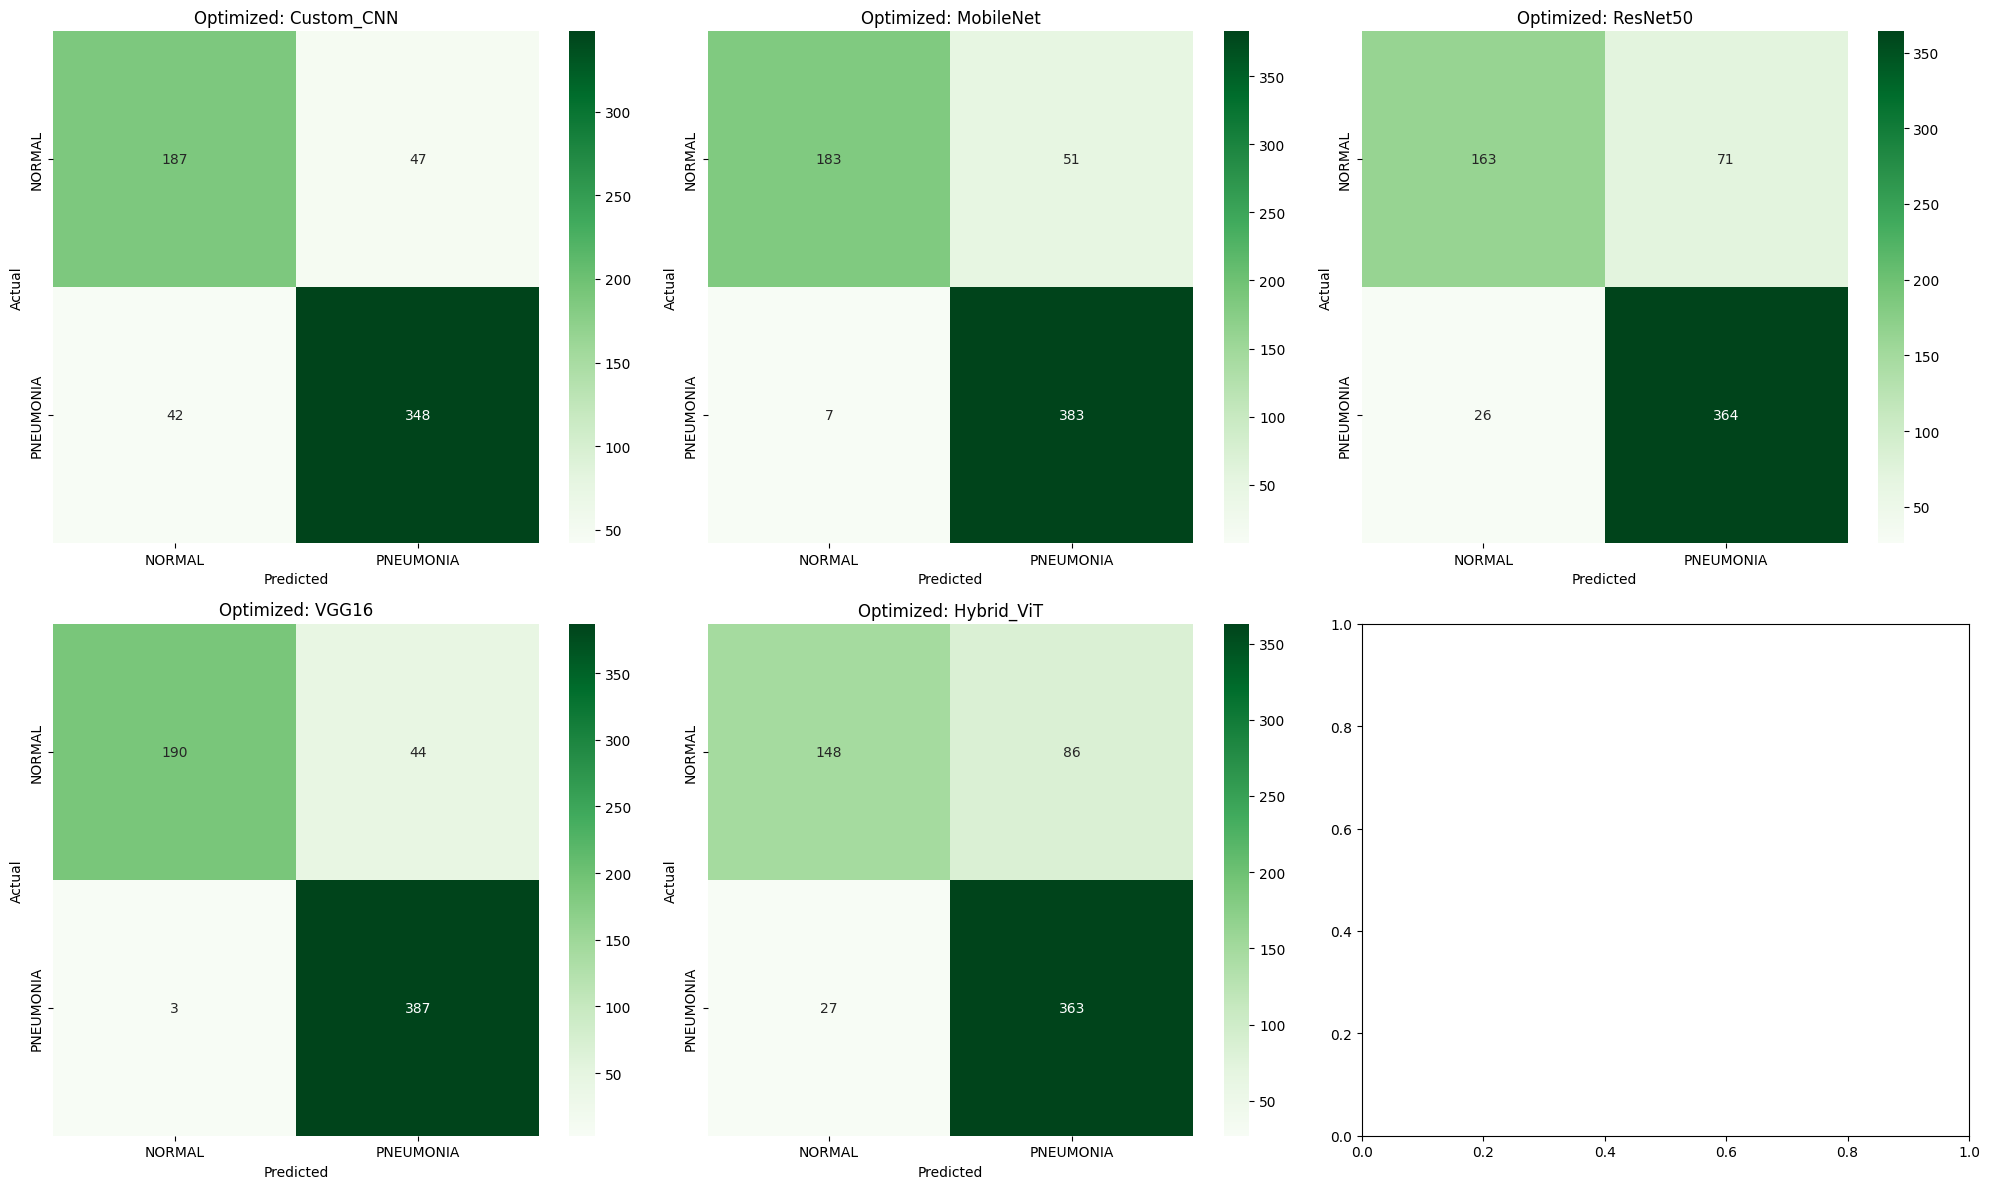


Final Report: Custom_CNN
              precision    recall  f1-score   support

      NORMAL       0.82      0.80      0.81       234
   PNEUMONIA       0.88      0.89      0.89       390

    accuracy                           0.86       624
   macro avg       0.85      0.85      0.85       624
weighted avg       0.86      0.86      0.86       624


Final Report: MobileNet
              precision    recall  f1-score   support

      NORMAL       0.96      0.78      0.86       234
   PNEUMONIA       0.88      0.98      0.93       390

    accuracy                           0.91       624
   macro avg       0.92      0.88      0.90       624
weighted avg       0.91      0.91      0.90       624


Final Report: ResNet50
              precision    recall  f1-score   support

      NORMAL       0.86      0.70      0.77       234
   PNEUMONIA       0.84      0.93      0.88       390

    accuracy                           0.84       624
   macro avg       0.85      0.81      0.83       624

In [5]:
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

for i, (name, data) in enumerate(results.items()):
    cm = confusion_matrix(data['y_true'], data['y_pred'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', ax=axes[i],
                xticklabels=['NORMAL', 'PNEUMONIA'], yticklabels=['NORMAL', 'PNEUMONIA'])
    axes[i].set_title(f'Optimized: {name}')
    axes[i].set_ylabel('Actual')
    axes[i].set_xlabel('Predicted')

plt.tight_layout()
plt.show()

for name, data in results.items():
    print(f"\n{'='*40}\nFinal Report: {name}\n{'='*40}")
    print(classification_report(data['y_true'], data['y_pred'], target_names=['NORMAL', 'PNEUMONIA']))

## 6. Metric Explanations

| Metric | Clinical Importance |
| :--- | :--- |
| **Recall** | **Most Important**: Ensures we don't miss any pneumonia cases (False Negatives). |
| **Precision** | Ensures we don't misdiagnose healthy patients as having pneumonia (False Positives). |
| **F1-Score** | Provides a balance between Precision and Recall. |
| **Confusion Matrix** | Directly shows the number of correct and incorrect diagnoses. |